## ME 405 HW 0x05: Full State Feedback
Authors: Matthew Frost and Ryan McLaughlin <br>
Originally Created: 05/09/21 <br>
Last Modified: 05/11/21 <br>
### Initial Setup and Variable Definitions

In [1]:
from sympy import *
init_printing()
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Create empty classes which are somewhat equivalent to MATLAB struct()
class functions:
    pass
class functions0:
    pass
class equations:
    pass
class equationNames:
    pass

Define fun, eqn, and eqnNames as the "structures." These will now allow for notation for fun.xB to save an equation xB within the ```functions``` class.

In [3]:
fun = functions()
fun0 = functions0()
eqn = equations()
eqnNames = equationNames()

Define symbolic variables (constants and functions of time)

In [4]:
r_C, t, r_B, r_G, m_B, m_P, I_bar_p_yy, M_y, g, T_x, L_p, r_M, I_B = symbols('r_C, t, r_B, r_G, m_B, m_P, \overline{I}_{pyy}, M_y, g, T_x, L_p, r_M I_B')     
x = Function('x')(t)
theta_y = Function('theta_y')(t)

Compute the moment of inertia of the ball, $\overline{I}_B$

In [5]:
I_B = I_B.subs([(Symbol('I_B'),.4*Symbol('m_B')*Symbol('r_B')**2)])

### 1) Ball Kinematics
X-Direction Kinematic Equations

In [6]:
fun.xB = (r_C + r_B)*sin(theta_y) + x*cos(theta_y) # x displacement of ball
# print('xB:')
# display(fun.xB)
fun.xBdot = diff(fun.xB,t)      # x velocity of ball
# print('xBdot:')
# display(fun.xBdot)
fun.xBddot = diff(fun.xBdot,t)  # x accceleration of ball
# print('xBddot:')
# display(fun.xBddot)

Z-Direction Kinematic Equations

In [7]:
fun.zB = (r_C + r_B)*cos(theta_y) - x*sin(theta_y) # z displacement of ball
# print('zB:')
# display(fun.zB)
fun.zBdot = diff(fun.zB,t)                        # z velocity of ball
# print('zBdot:')
# display(fun.zBdot)
fun.zBddot = diff(fun.zBdot,t)                    # z acceleration of ball
# print('zBddot:')
# display(fun.zBddot)

### 2) Motor Torque to Platform Moment

Define the effective moment on the platform, $ M_y $ in terms of the input motor torque, $ T_x $

In [8]:
## DEFINE My IN TERMS OF MOTOR TORQUE
M_y = -L_p*T_x/r_M
# display(M_y)

### 3) Equations of Motion
##### 3.1) System 1: Ball and Platform Together

In [9]:
fun0.lhs1 = m_P*g*r_G*sin(theta_y) + m_B*g*( (r_C+r_B)*sin(theta_y)+x*cos(theta_y) ) + M_y;
fun0.rhs1 = ((I_bar_p_yy + m_P*r_G**2)*diff(theta_y,t,2) 
              - m_B*fun.zBddot*( (r_C+r_B)*sin(theta_y)+x*cos(theta_y) )
              + m_B*fun.xBddot*( (r_C+r_B)*cos(theta_y)-x*sin(theta_y)) 
              + (I_B)*((diff(x,t,2)/r_B) + diff(theta_y,t,2)));
fun0.EOM1 = Eq(fun0.lhs1,fun0.rhs1)
fun.EOM1  = fun0.EOM1.subs([(diff(x,t,2),Symbol('\ddot{x}')),(diff(x,t),Symbol('\dot{x}')),
                             (diff(theta_y,t,2),Symbol('\ddot{\\theta}_y')),(diff(theta_y,t),Symbol('\dot{\\theta}_y')),
                             (x,Symbol('x')),(theta_y,Symbol('\\theta_y'))])
# print('EOM1')
# display(fun.EOM1);

#### 3.2) System 2: Ball Only

In [10]:
fun0.lhs2 = m_B*g*r_B*sin(theta_y);
fun0.rhs2 = (-m_B*fun.zBddot*r_B*sin(theta_y)
            + m_B*fun.xBddot*r_B*cos(theta_y) 
            + (I_B)*((diff(x,t,2)/r_B) + diff(theta_y,t,2)));
fun0.EOM2 = Eq(fun0.lhs2,fun0.rhs2)
fun.EOM2 = fun0.EOM2.subs([(diff(x,t,2),Symbol('\ddot{x}')),(diff(x,t),Symbol('\dot{x}')),
                             (diff(theta_y,t,2),Symbol('\ddot{\\theta}_y')),(diff(theta_y,t),Symbol('\dot{\\theta}_y')),
                             (x,Symbol('x')),(theta_y,Symbol('\\theta_y'))])
# print('EOM2')
# display(fun.EOM2)

### 4) Convert EOM's to Matrix Form
Next, the ```linear_eq_to_matrix``` function (similar to ```equationsToMatrix``` in MATLAB®) is used.

In [11]:
# eqnsForMatrix = Matrix([[fun.EOM1],[fun.EOM2]])
# varsForMatrix = Matrix([[diff(theta_y,t,2)],[diff(x,t,2)]])
M, f = linear_eq_to_matrix([fun.EOM1, fun.EOM2], [Symbol('\ddot{x}'), Symbol('\ddot{\\theta}_y')])
# print('The M matrix is:')
# display(simplify(M))
# print('The f matrix is:')
# display(simplify(f))

Convert matrices to form of $x=M^{-1}f$

In [12]:
G = simplify(M.inv()*f)
# print('xDotMatrix')
# display(xDotMatrix)
h = Matrix([[Symbol('\dot{x}')], [Symbol('\dot{\\theta}_y')],[G[0]],[G[1]]])
# display(G)

Create $h$ matrix for state space representation

In [13]:
# CREATE h MATRIX FOR STATE SPACE
h = Matrix([[Symbol('\dot{x}')], [Symbol('\dot{\\theta}_y')],[G[0]],[G[1]]])
# print('h')
# display(h)

### 5) Jacobian Linearization
Define the state variable matrix

In [14]:
x_vec_variables = Matrix([[Symbol('x')],[Symbol('\\theta_y')],[Symbol('\dot{x}')],[Symbol('\dot{\\theta}_y')]])

Compute the Jacobian with respect to the state vector, and define operating point by subsituting zeros for all state variables present

In [15]:
Jx = h.jacobian(x_vec_variables)
Jx_subbed = Jx.subs([(Symbol('x'),0),(Symbol('\\theta_y'),0),(Symbol('\dot{x}'),0),(Symbol('\dot{\\theta}_y'),0)])
# display(Jx_subbed)

Substitue values for all other constants to determine a numerical form of the $A$ matrix
    
$r_M$, $r_B$, $r_G$, $L_p$, $r_C$ = [ m ]

$m_B$, $m_P$ = [ kg ]

$I_b$ = [ kg-m^2 ]

$x$, $y$ = [ m ]

$\dot{x}$, $\dot{y}$ = [ m/s ]

$\theta_y$ = [ rad ]

$\dot{\theta}_y$ = [ rad/s ]

$T_x$ = [ Nm ]

In [16]:
A = Jx_subbed.subs([(r_M,0.06),(r_B,0.0105),(r_G, 0.042),(L_p, 0.110),(r_C, 0.050),(m_B, 0.030),(m_P, 0.400),(I_bar_p_yy, 1.88e-3),(g,9.81),(Symbol('x'),0),(Symbol('\\theta_y'),0),(Symbol('\dot{x}'),0),(Symbol('\dot{\\theta}_y'),0),(Symbol('T_x'),0)])
# print('A Matrix:')
# display(A)

Compute the Jacobian with respect to the input vector, define operating point, and substitute numerical values to determine $B$ matrix

In [17]:
Ju = h.jacobian([Symbol('T_x')])
Ju_subbed = Ju.subs([(Symbol('x'),0),(Symbol('\\theta_y'),0),(Symbol('\dot{x}'),0),(Symbol('\dot{\\theta}_y'),0),(Symbol('T_x'),0)])
# display(Ju_subbed)

In [18]:
B = Ju_subbed.subs([(r_M,0.06),(r_B,0.0105),(r_G, 0.042),(L_p, 0.110),(r_C, 0.050),(m_B, 0.030),(m_P, 0.400),(I_bar_p_yy, 1.88e-3),(g,9.81),(Symbol('x'),0),(Symbol('\\theta_y'),0),(Symbol('\dot{x}'),0),(Symbol('\dot{\\theta}_y'),0),(Symbol('T_x'),0)])
# print('B Matrix')
display(B)

⎡        0        ⎤
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢32.4991415148792 ⎥
⎢                 ⎥
⎣-703.227173428607⎦

### 6) Simulation of State Space Model
After linearizing the system, we are now ready to use the ```scipy``` Python library to simulate the time response of the balancing platform system in both open- and closed-loop configurations

In [19]:
from scipy.signal import lti, lsim
from numpy import array, eye, linspace, ones, round, zeros_like, multiply
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '9'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = 'times'

Define a matrix $K$ that contains the controller gains $K_1$, $K_2$, $K_3$, $K_4$. 

In [20]:
# Define K matrix
K1, K2, K3, K4, s = symbols('K1, K2, K3, K4, s')
K = Matrix([[K1, K2, K3, K4]])

Define the closed loop matrix that implements the full-state feedback control, $A_{CL}$.

In [21]:
# Define closed-loop gain matrix
Acl = simplify(A-B*K)
display(Acl)

⎡                   0                                       0                 
⎢                                                                             
⎢                   0                                       0                 
⎢                                                                             
⎢-32.4991415148792⋅K₁ - 5.21699855336125  4.01109511649826 - 32.4991415148792⋅
⎢                                                                             
⎣703.227173428607⋅K₁ + 112.887140258203   703.227173428607⋅K₂ + 64.82947197685

             1                     0          ⎤
                                              ⎥
             0                     1          ⎥
                                              ⎥
K₂  -32.4991415148792⋅K₃  -32.4991415148792⋅K₄⎥
                                              ⎥
38  703.227173428607⋅K₃   703.227173428607⋅K₄ ⎦

Find the characteristic polynomial by taking the ````det(sI-Acl)```` and then equate the coefficients of the polynomial to the variables a0 through a3. These are in terms of the $K$ matrix, and will eventually solved for the $K$ values, which will provide a controller gain matrix.

In [22]:
# Find characteristic polynomial
detMatrix = s*eye(4) - Acl
P_s = simplify(detMatrix.det())

# Find the coefficients of the polynomial
a = Poly(P_s, s)
a3 = a.coeffs()[1]
a2 = a.coeffs()[2]
a1 = a.coeffs()[3]
a0 = a.coeffs()[4]

In order to locate the desired poles, a reasonable settling time of 2 seconds and overshoot of 20% was chosen. This will allow for the damping ratio, $\zeta$, and natural frequency, $\omega_n$ to be derived.

In [24]:
## Find the natural frequency and %OS that is desired
from math import sqrt, pi, log
Ts, wn, zeta, OS = symbols(u'T_s, omega_n, zeta, OS')
Ts = 2
OS = 0.01
zeta = -log(OS)/sqrt(pi**2 + (log(OS))**2)
wn = 4/(Ts*zeta)

After the damping ratio, $\zeta$, and natural frequency, $\omega_n$ are determined, a second order response can be determined in the form of $s^2 + 2\zeta \omega_n s + \omega_n^2$. This will allow for two complex conjugate poles to be derived. 

In [25]:
## Find desired polynomial and coefficients from chosen poles
from numpy import roots, real
pole_1_2_coeff = [1, 2*zeta*wn, wn**2]
pole_1 = roots(pole_1_2_coeff)[0]
pole_2 = roots(pole_1_2_coeff)[1]

After finding the desired poles, since two more are still required (based on the order of the characteristic polynomial). These are chosed as multiples of the real part of the desired poles. The first one is 8 times further to the left of the previously derived poles, and the second is 10 times further to the left. This will provide reasonable distance between poles so that the last two poles don't interfere too dramatically with the results, but not too far to create an impractical model.

In [26]:
# Choose poles that are over 8x and 10x the real portion of poles 1 and 2
pole_3 = 8*real(pole_1)
pole_4 = 10*real(pole_1)

Find the desired characteristic polynomial based on the chosen poles. Find the coefficients of this characteristic polynomial, which also represent a0 through a3, but this time, they have values, not expressions of $K$.

In [27]:
# Find actual characteristic polynomial
P_act = expand((s-pole_1)*(s-pole_2)*(s-pole_3)*(s-pole_4))
P_act_poly = Poly(P_act, s)

# Find the coefficients of the desired characteristic polynomial
P_act_coeff_3 = P_act_poly.coeffs()[1]
P_act_coeff_2 = P_act_poly.coeffs()[2]
P_act_coeff_1 = P_act_poly.coeffs()[3]
P_act_coeff_0 = P_act_poly.coeffs()[4]

After finding the desired values of a0 through a3, they must be equated to the ones derived from the actual polynomial (from taking the ````det(sI-Acl)````). This can then be solved with linear algebra to find the $K$ matrix.

In [28]:
## Find K1, K2, K3, and K4
eqn3 = Eq(a3,P_act_coeff_3)
eqn2 = Eq(a2,P_act_coeff_2)
eqn1 = Eq(a1,P_act_coeff_1)
eqn0 = Eq(a0,P_act_coeff_0)

# Solve for the K matrix
[M,N] = linear_eq_to_matrix([eqn0, eqn1, eqn2, eqn3], [K1, K2, K3, K4])
K = linsolve((M,N))

# Take K values out of a "FiniteSet" and into a list to allow for indexing
K_parsed = (K.args[0])
display(K_parsed)

After finding the $K$ matrix, the results must be validated that they produce the requested poles. The four poles requested are about: -2 + 3.9j, -2 - 3.9j, -16, -20.

In [29]:
## Verify that calculations are correct. The eigenvalues of the A-B*K matrix should
## bring back the poles of -2 + ~3.9j, -2 - ~3.9j, -16, -20
A_CL = Acl.subs([(K1,K_parsed[0]),(K2,K_parsed[1]),(K3,K_parsed[2]),(K4,K_parsed[3])])
# display(A_CL)
eigenvalues = list(A_CL.eigenvals().keys())
eig1 = eigenvalues[0]
eig2 = eigenvalues[1]
eig3 = eigenvalues[2]
eig4 = eigenvalues[3]
display(eig1.evalf())
display(eig2.evalf())
display(eig3.evalf())
display(eig4.evalf())

### 6.1) Closed Loop Simulation
Initial conditions and controller: Ball is at rest on a level platform, offset 5 cm horizontally from the center of the platform, and closed-loop feedback is utilized <br> <br> Define the controller gain matrix, and find the new $A$, $B$, $C$, and $D$ matrices 

From before, the C and D matrices are defined as follows:

In [30]:
CC = array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
DD = array([[0], [0], [0], [0]])

The $A_{CL}$ matrix is then solved for by plugging in the numerical values from the $K$ matrix. Additionally, the $C_{CL}$ and $D_{CL}$ matrices are defined as before, this time with the new controller matrix however.

In [31]:
A_CL = Acl.subs([(K1,K_parsed[0]),(K2,K_parsed[1]),(K3,K_parsed[2]),(K4,K_parsed[3])])
B_CL = array([[0], [0], [0], [0]])
C_CL = CC-DD*K_parsed
D_CL = array([[0], [0], [0], [0]]) 

Define a linear, time-invariant state space system based on the $A$, $B$, $C$, and $D$ matrices defined above using the ```scipy.lti```. 

In [32]:
ltiSystemClosed_HW0x05 = lti(A_CL, B_CL, C_CL, D_CL)

Plot the response of the system. 

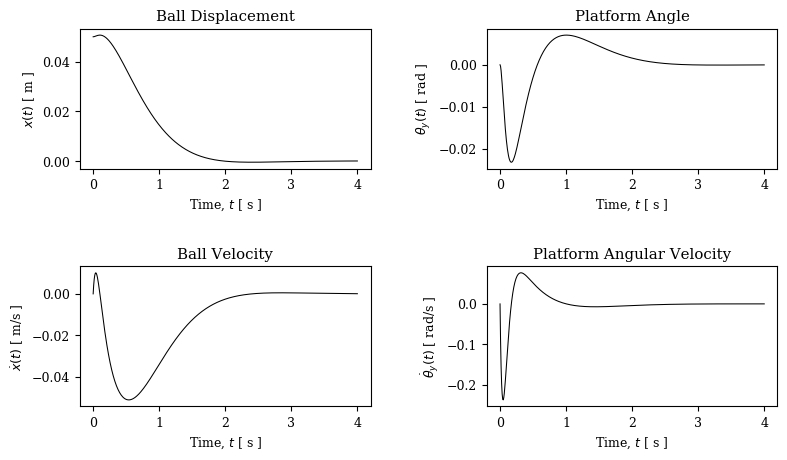

In [33]:
t4 = linspace(0, 4, num=500)
u = zeros_like(t)
x0 = array([[0.05, 0, 0, 0]])

tout4, y4, x4 = lsim(ltiSystemClosed_HW0x05, U = u, T = t4, X0 = x0)

fig4,axs4 = plt.subplots(2,2,figsize = (9,5), dpi = 100, constrained_layout=True)
plt.subplots_adjust(hspace = 0.7,wspace = 0.4)

axs4[0,0].plot(t4, y4[:,0],'k',linewidth = 0.75)
axs4[0,0].set(title='Ball Displacement',xlabel = r'Time, $t$ [ s ]',ylabel = r'$x(t)$ [ m ]')
axs4[0,1].plot(t4, y4[:,1],'k',linewidth = 0.75)
axs4[0,1].set(title='Platform Angle',xlabel = r'Time, $t$ [ s ]',ylabel = r'${\theta}_y(t)$ [ rad ]')
axs4[1,0].plot(t4, y4[:,2],'k',linewidth = 0.75)
axs4[1,0].set(title='Ball Velocity',xlabel = r'Time, $t$ [ s ]',ylabel = r'$\dot{x}(t)$ [ m/s ]')
axs4[1,1].plot(t4, y4[:,3],'k',linewidth = 0.75)
axs4[1,1].set(title='Platform Angular Velocity',xlabel = r'Time, $t$ [ s ]',ylabel = r'$\dot{\theta}_y(t)$ [ rad/s ]')

plt.show()
fig4.savefig('405_HW0x05_ClosedLoop.png')